# **DALL-E image generation**

In [2]:
import torch
import numpy as np
from skimage import io
import os
from tqdm import tqdm
from PIL import Image
import base64
from openai import OpenAI
import requests

from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from io import BytesIO


In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Notebook for **image generation using DALL-E 2 and DALL-E 3** on:
- CMC dataset (Fiber Beads microCT images)
- Rocksample dataset (microCT scans from samples containing large sediment grains from the Hanford DOE contaminated nuclear site)
- EcoFAB images (2D scanned RGB plant root images)

We evaluate different endpoint of DALL-E 2 and DALL-E 3:
- DALL-E 2 **edit** for image inpainting
- DALL-E 2 **variation** for semantic variation
- DALL-E 2 **generation** for text-to-image generation using DALL-E 2
- DALL-E 3 **generation** for text-to-image generation using DALL-E 3

We infer 2 or 3 images for each input image of a given dataset to generate between 1000 to 2000 images.

In [4]:
# Add your OpenAI Key here
openai_key = "your_openai_key"

# Add the path of the basefolder where the data is located and the generated samples will be save later in the notebook
basepath = "/content/drive/MyDrive/CAMERA Stable Diffusion"

In [5]:
def encode_image(image_path):
  """
  Encodes an image file as a base64 string.

  Args:
    image_path (str): The path to the image file.

  Returns:
    A string containing the base64 encoded image data.
  """
  with open(image_path, "rb") as image_file:
      encoded_string = base64.b64encode(image_file.read()).decode('utf-8')

  return encoded_string


def generate_img_description(api_key, image_path):
  """
  Generates a description of an image using the OpenAI GPT-4 Vision API.

  Args:
    api_key: The API key for the OpenAI GPT-4 Vision API.
    image_path: The path to the image file.

  Returns:
    A string containing the generated description of the image.
  """
  # Set your OpenAI API key
  client = OpenAI(api_key=api_key)

  # Encode image
  base64_image = encode_image(image_path)

  # Send request to GPT-4 Vision
  response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[
          {
              "role": "user",
              "content": [
                  {
                      "type": "text",
                      "text": "What is in this image?",
                  },
                  {
                      "type": "image_url",
                      "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                  },
              ],
          }
      ],
  )

  # Return the generated text description
  return response.choices[0].message.content


In [6]:
def create_mask(size, save_path):
  """
  Create mask for edit mode of DALL-e 2 of the region to modify (to run only once and save it in same directory as notebook, path can be modified to prefered directory).
  Args:
    size: The size of the mask to create.
    save_path: The path to save the mask.
  Returns:
    None
  """

  shape = size.split("x")[0]
  width = int(shape)
  height = int(shape)
  mask = Image.new("RGBA", (width, height), (0, 0, 0, 1))  # create an opaque image mask
  # set the bottom half to be transparent
  for x in range(width):
      for y in range(height // 2, height):  # only loop over the bottom half of the mask
          # set alpha (A) to zero to turn pixel transparent
          alpha = 0
          mask.putpixel((x, y), (0, 0, 0, alpha))
  mask_name = "bottom_half_mask_{}.png".format(width)
  mask_name = os.path.join(save_path, mask_name)
  mask.save(mask_name)
  print(np.array(mask).shape)
  print("Mask saved as {}".format(mask_name))

In [7]:
def dalle_generator(openai_key,
                    image_path,
                    mask_name,
                    dalle="dall-e-2",
                    mode="generation",
                    prompt=None,
                    n=5,
                    size="512x512",
                    save=False,
                    path_tosave=None
                    ):
  """
  Generates images from a given DALL-E model using the OpenAI API.

  Args:
    api_key (str): The API key for the OpenAI API.
    image_path (str): The path to the image to use for generation, editing or variation. Even if not needed for generation, add path for plotting.
    mask_name (str): The name of the mask to use for editing. Default set to "bottom_half_mask_512.png".
    dalle (str): The name of the DALL-E model to use. It can either be "dall-e-2" or "dall-e-3".
    mode (str): The mode to use for image generation. It can be either "variation", "edit" or "generation".
    prompt (str): The prompt to use for image generation. If gpt-4o descriptive prompt is needed, then set prompt="gpo4o", otherwise just enter your custom prompt.
    n (int): The number of images to generate and save. Default set to 5.
    size (str): The size of the generated images. Default to 512x512.
    save (bool): Whether to save the generated images. Default to False.
    path_tosave (str): The path to save the generated images. Default to None.

  Returns:
    A list of generated images.

  """

  lst_imgs = []
  client = OpenAI(api_key=openai_key)

  if prompt == "gpt4o":
    gpt4o_prompt = generate_img_description(openai_key, image_path)
    print("This is the description of the input image generated by GPT-4o: {}".format(gpt4o_prompt))

  if mode == "edit":
    response = client.images.edit(
        image=open(image_path, "rb"),
        mask=open(mask_name, "rb"),
        prompt=prompt,
        n=n,
        size=size
      )
  elif mode == "generation": # either custom prompt or gpt4o generated
    if prompt == "gpt4o":
      prompt = gpt4o_prompt

    response = client.images.generate(
        model=dalle,
        prompt=prompt,
        size=size,
        n=n,
    )

  elif mode == "variation":
    response = client.images.create_variation(
      model=dalle,
      image=open(image_path, "rb"),
        n=n,
        size=size,
    )


  for i, img_data in enumerate(response.data):
    img_url = img_data.url

    # Download the image
    image_data = requests.get(img_url).content

    # Append image to list for visualization
    image = Image.open(BytesIO(image_data)).convert("RGB")
    image_np = np.array(image)

    lst_imgs.append(image_np)

    # Save the image
    if save:
      filename = os.path.basename(image_path).split(".")[0]
      if prompt == "gpt4o":
        path_filename = os.path.join(path_tosave, "{}_{}_{}_{}_{}.png".format(dalle, mode, prompt, filename, i))
      else:
        path_filename = os.path.join(path_tosave, "{}_{}_{}_{}.png".format(dalle, mode, filename, i))
    with open(path_filename, "wb") as f:
        f.write(image_data)

    print(f"Saved: {path_filename}")


  # Plot the 5 images
  fig, ax = plt.subplots(1, n+1, figsize=(20, 8))
  for i in range(n):
    if lst_imgs[i].shape[2] == 3: # RGB image
      ax[0].imshow(io.imread(image_path))
      ax[i+1].imshow(lst_imgs[i])
    else:
      ax[0].imshow(io.imread(image_path), cmap='gray')
      ax[i+1].imshow(lst_imgs[i], 'gray')
    ax[0].axis('off')
    ax[i+1].axis('off')
  plt.tight_layout()
  plt.show()

  return None


In [51]:
# Checking if my api_key includes/authorizes the models I need for inference
client = OpenAI(api_key=openai_key)
response = client.models.list()
print([m.id for m in response.data])

['dall-e-3', 'dall-e-2', 'gpt-4o-mini']


In [8]:
def dalle_generation(data, model, mode, custom_prompt, nb_samples, shape_img="512x512"):
  """
  Generates images from a given DALL-E model using the OpenAI API.

  Args:
    data (str): The name of the dataset. Can be either "ROCKS", "CMC" or "ROOTS".
    model (str): The name of the DALL-E model to use. Can be either "dall-e-2" or "dall-e-3"
    mode (str): The mode to use for image generation. Can be either "variation", "edit" or "generation".
    custom_prompt (str): The prompt to use for image generation.
    nb_samples (int): The number of images to generate and save.
    shape_img (str): The size of the generated images. Can either be "512x512" for dall-e-2 or "1024x1024" for dall-e-2. Default to "512x512".

  Returns:
    A list of generated images.
  """
  data_path = os.path.join(basepath, "data_tutorial/raw/{}".format(data))

  # Create the list of input images to loop over
  lst_imgs_raw = [e for e in os.listdir(data_path) if not e.startswith(".")]
  print("Number of input images available: {}".format(len(lst_imgs_raw)))

  # Create the list of output images to not generate from input images previously used
  save_rootpath = os.path.join(basepath, "data_tutorial/generated/{}/{}".format(data, model + '_' + mode))
  os.makedirs(save_rootpath, exist_ok=True)

  save_list = [os.path.splitext(e)[0].split(mode+'_')[-1][:-2] for e in os.listdir(save_rootpath) if not e.startswith(".")]
  print("Number of generated images available: {}".format(len(save_list)))

  for img_path in tqdm(lst_imgs_raw):
    filename = os.path.splitext(img_path)[0]
    if filename not in save_list:
      print("Processing image {}".format(filename))
      dalle_generator(openai_key,
                      image_path=os.path.join(data_path, img_path),
                      dalle=model, mode=mode,
                      mask_name=os.path.join(basepath, "data_tutorial/bottom_half_mask_512.png"),
                      prompt=custom_prompt,
                      n=nb_samples,
                      size=shape_img,
                      save=True,
                      path_tosave=save_rootpath)
    else:
      print("Image {} already processed".format(filename))

**DALL-e 2 edit**

Paths to datasets for:
- Rocksample: */content/drive/MyDrive/CAMERA Stable Diffusion/data/rocksample_512_uint8_rgb*
- EcoFAB: */content/drive/MyDrive/CAMERA Stable Diffusion/data/ecofab_cropped512_exp1exp2_nocondensation*
- CMC: */content/drive/MyDrive/CAMERA Stable Diffusion/data/cmc_512_png*

Prompts:
- ROCKS: *microCT scan from a rock sample containing large sediment grains seperated by pores*
- ROOTS: *microscopy image of entangled
plant root in hydroponic system*
- CMC: *an X-ray image of a composite material with deformed circles*

In [55]:
# Create the mask of the inpainting location once
create_mask("512x512", save_path=os.path.join(basepath, "data_tutorial")) # create a mask for image inpainting with the same shape as the input image

(512, 512, 4)
Mask saved as /content/drive/MyDrive/CAMERA Stable Diffusion/data_tutorial/bottom_half_mask_512.png


In [56]:
data = 'ROCKS' # Choose from ROCKS, CMC or ROOTS.
model = "dall-e-2" # Choose from dall-e-2 or dall-e-3.
mode = "edit" # Choose from edit, variation or generation.

custom_prompt = "microCT scan from a rock sample containing large sediment grains seperated by pores" # you can modify the prompt as you see fit
nb_samples = 3
dalle_generation(data, model, mode, custom_prompt, nb_samples)


Number of input images available: 3
Number of generated images available: 6


100%|██████████| 3/3 [00:00<00:00, 7849.60it/s]

Image Empty-Fe-Sand-10x_101 already processed
Image Empty-Fe-Sand-10x_48 already processed
Image Empty-Fe-Sand-10x_7 already processed


Number of input images available: 3
Number of generated images available: 0


  0%|          | 0/3 [00:00<?, ?it/s]

Processing image Wet_raw43_0036
Saved: /content/drive/MyDrive/CAMERA Stable Diffusion/data_tutorial/generated/CMC/dalle2_edit/dalle2_edit_Wet_raw43_0036_0.png
Saved: /content/drive/MyDrive/CAMERA Stable Diffusion/data_tutorial/generated/CMC/dalle2_edit/dalle2_edit_Wet_raw43_0036_1.png
Saved: /content/drive/MyDrive/CAMERA Stable Diffusion/data_tutorial/generated/CMC/dalle2_edit/dalle2_edit_Wet_raw43_0036_2.png


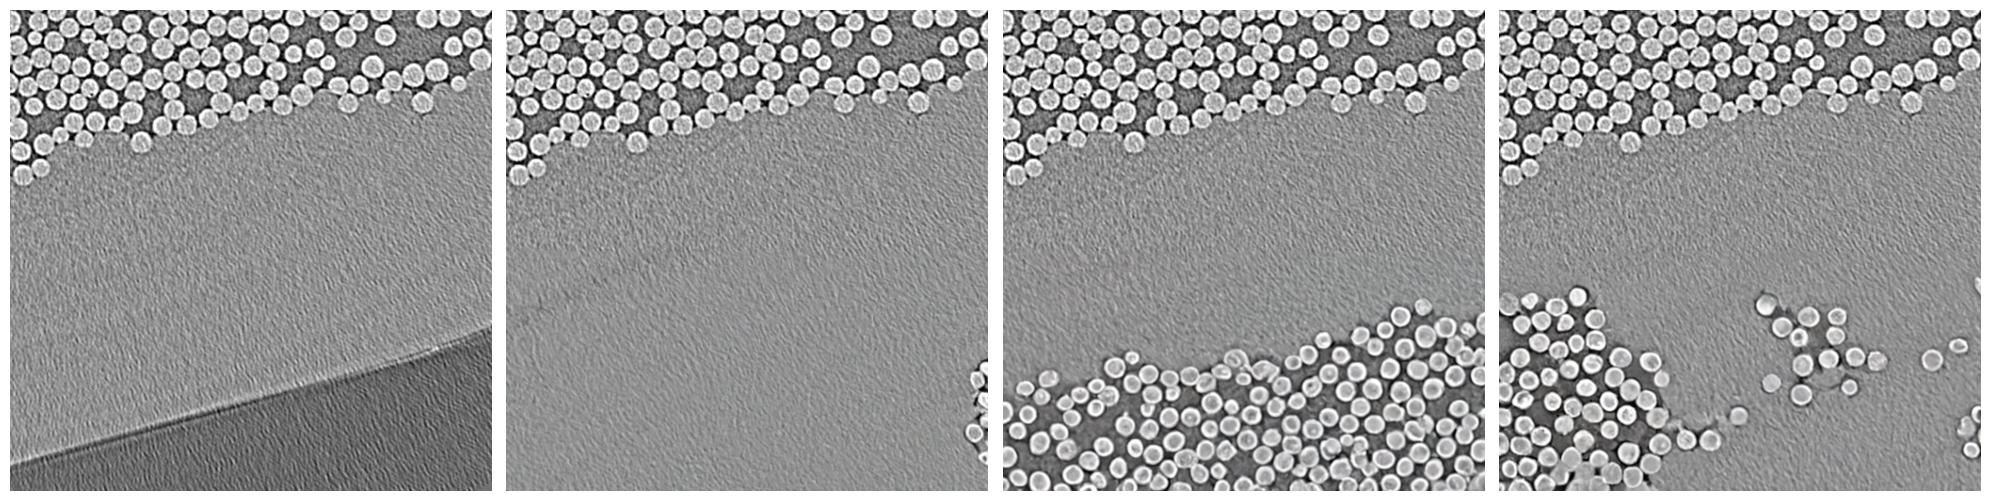

 33%|███▎      | 1/3 [00:17<00:35, 17.78s/it]

Processing image Wet_raw42_0023
Saved: /content/drive/MyDrive/CAMERA Stable Diffusion/data_tutorial/generated/CMC/dalle2_edit/dalle2_edit_Wet_raw42_0023_0.png
Saved: /content/drive/MyDrive/CAMERA Stable Diffusion/data_tutorial/generated/CMC/dalle2_edit/dalle2_edit_Wet_raw42_0023_1.png
Saved: /content/drive/MyDrive/CAMERA Stable Diffusion/data_tutorial/generated/CMC/dalle2_edit/dalle2_edit_Wet_raw42_0023_2.png


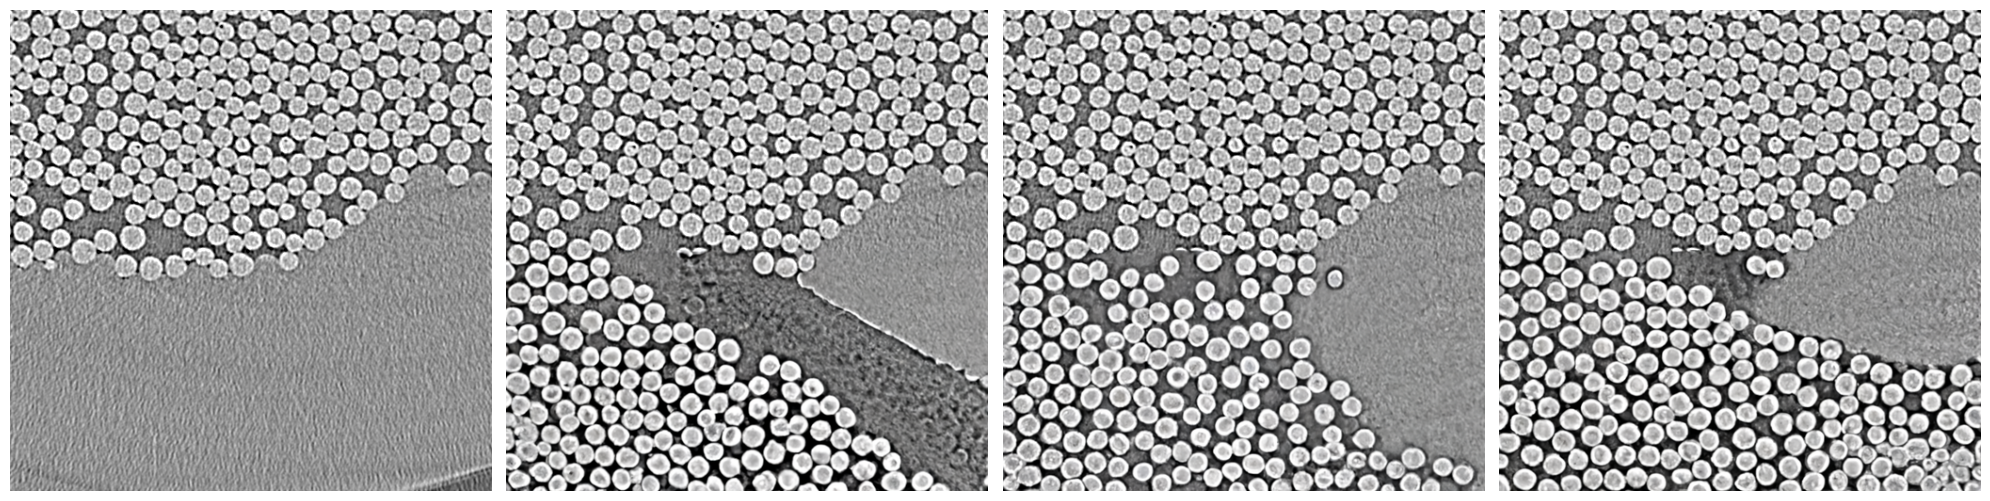

 67%|██████▋   | 2/3 [00:35<00:17, 17.99s/it]

Processing image Wet_raw42_0043
Saved: /content/drive/MyDrive/CAMERA Stable Diffusion/data_tutorial/generated/CMC/dalle2_edit/dalle2_edit_Wet_raw42_0043_0.png
Saved: /content/drive/MyDrive/CAMERA Stable Diffusion/data_tutorial/generated/CMC/dalle2_edit/dalle2_edit_Wet_raw42_0043_1.png
Saved: /content/drive/MyDrive/CAMERA Stable Diffusion/data_tutorial/generated/CMC/dalle2_edit/dalle2_edit_Wet_raw42_0043_2.png


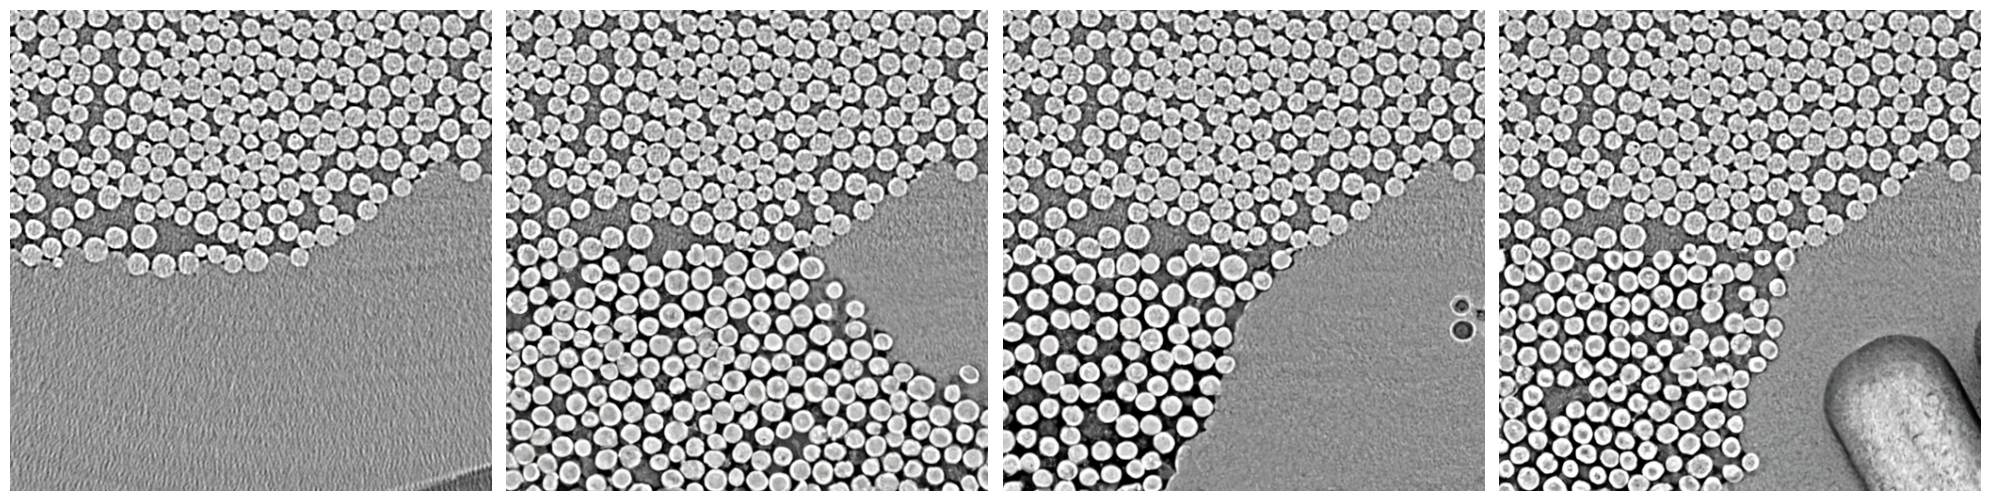

100%|██████████| 3/3 [00:53<00:00, 17.70s/it]


In [57]:
data = 'CMC' # Choose from ROCKS, CMC or ROOTS
model = "dall-e-2"
mode = "edit" # Choose from edit, variation or generation
custom_prompt = "an X-ray image of a composite material with deformed circles" # you can modify the prompt as you see fit
nb_samples = 3
dalle_generation(data, model, mode, custom_prompt, nb_samples)


In [ ]:
data = 'ROOTS' # Choose from ROCKS, CMC or ROOTS
model = "dall-e-2"
mode = "edit" # Choose from edit, variation or generation
custom_prompt = "microscopy image of entangled plant root in hydroponic system" # you can modify the prompt as you see fit
nb_samples = 3
dalle_generation(data, model, mode, custom_prompt, nb_samples)


**DALL-e 2 variation**

In [ ]:
data = 'ROOTS' # Choose from ROCKS, CMC or ROOTS.
model = "dall-e-2" # Choose from dall-e-2 or dall-e-3.
mode = "variation" # Choose from edit (only for dall-e-2), variation(only for dall-e-2) or generation (for dall-e-2 and dall-e-3).

nb_samples = 3
custom_prompt = "None" # There is no guiding prompt for this endpoint
dalle_generation(data, model, mode, custom_prompt, nb_samples)


In [ ]:
data = 'CMC' # Choose from ROCKS, CMC or ROOTS.
model = "dall-e-2" # Choose from dall-e-2 or dall-e-3.
mode = "variation" # Choose from edit (only for dall-e-2), variation(only for dall-e-2) or generation (for dall-e-2 and dall-e-3).

nb_samples = 3
custom_prompt = "None" # There is no guiding prompt for this endpoint
dalle_generation(data, model, mode, custom_prompt, nb_samples)


In [61]:
data = 'ROCKS' # Choose from ROCKS, CMC or ROOTS.
model = "dall-e-2" # Choose from dall-e-2 or dall-e-3.
mode = "variation" # Choose from edit (only for dall-e-2), variation(only for dall-e-2) or generation (for dall-e-2 and dall-e-3).

nb_samples = 3
custom_prompt = "None" # There is no guiding prompt for this endpoint
dalle_generation(data, model, mode, custom_prompt, nb_samples)


Number of input images available: 3
Number of generated images available: 6


100%|██████████| 3/3 [00:00<00:00, 9671.72it/s]

Image Empty-Fe-Sand-10x_101 already processed
Image Empty-Fe-Sand-10x_48 already processed
Image Empty-Fe-Sand-10x_7 already processed


**DALL-e 2 generation custom prompt**

In [ ]:
data = 'CMC' # Choose from ROCKS, CMC or ROOTS.
model = "dall-e-2" # Choose from dall-e-2 or dall-e-3.
mode = "generation" # Choose from edit (only for dall-e-2), variation(only for dall-e-2) or generation (for dall-e-2 and dall-e-3).

nb_samples = 3
custom_prompt = "an X-ray image of a composite material with deformed circles"
dalle_generation(data, model, mode, custom_prompt, nb_samples)

In [ ]:
data = 'ROCKS' # Choose from ROCKS, CMC or ROOTS.
model = "dall-e-2" # Choose from dall-e-2 or dall-e-3.
mode = "generation" # Choose from edit (only for dall-e-2), variation(only for dall-e-2) or generation (for dall-e-2 and dall-e-3).

nb_samples = 3
custom_prompt = "microCT scan from a rock sample containing large sediment grains seperated by pores"
dalle_generation(data, model, mode, custom_prompt, nb_samples)


In [ ]:
data = 'ROOTS' # Choose from ROCKS, CMC or ROOTS.
model = "dall-e-2" # Choose from dall-e-2 or dall-e-3.
mode = "generation" # Choose from edit (only for dall-e-2), variation(only for dall-e-2) or generation (for dall-e-2 and dall-e-3).

nb_samples = 3
custom_prompt = "microscopy image of entangled plant root in hydroponic system"
dalle_generation(data, model, mode, custom_prompt, nb_samples)


**DALL-e-3 generation**

In [ ]:
lst_prompts = ["an X-ray image of a composite material with deformed circles",  # CMC prompt
               "microCT scan from a rock sample containing large sediment grains seperated by pores", # ROCKS prompt
               "microscopy image of entangled plant root in hydroponic system"] # ROOTS prompt

# The endpoint API for dall-e-3 can only generated one sample at a time, so an extra for loop is needed
nb_samples_loop = 3
model = "dall-e-3"
mode = "generation"
for data_type, custom_prompt in zip(['CMC', 'ROCKS', 'ROOTS'], lst_prompts):
  print("Processing {} with dall-e-3 generatione endpoint".format(data_type))

  for _ in range(nb_samples_loop):
    dalle_generation(data_type, model, mode, custom_prompt, nb_samples=1, shape_img="1024x1024")